# <center> Restaurant Recommendation In Mumbai </center>

## Introduction 

Mumbai is the capital city of the Indian state of Maharashtra. According to the United Nations, as of 2018, Mumbai is the second-most populous city in the country after Delhi and the seventh-most populous city in the world with a population of roughly 20 million. Mumbai is the financial, commercial, and the entertainment capital of India. It lies on the west coast of India and attracts heavy tourism from all over the globe every year. People from various different culture reside here. In short, Mumbai is a place of extreme diversity. Due to the multi-cultured nature of the place, many different cuisines and variety of flavors are found here. So, targeting the right place, one can open a profitable restaurant in Mumbai.

## Problem

So, the main motive of this project is to analyze the neighborhood in Mumbai and answer the question ***What is the best place to start a restaurant in Mumbai?*** <br>
This project aims to help any person wanting to open a restaurant or invest in a restaurant in Mumbai.

## Data

A brief description of the data used in this project: <br>
1. Neighborhood data: This data is collected from the wikipedia page https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai. This page contains a very well tabulated data that includes all the neighborhoods, their location and their geographical coordinates.
2. Geographical Coordinates: This data is obtained using the geocoder library in Python. Although, our original dataset does have geographical coordinates, we will replace it with the coordinates obtained by the geopy library.
3. Foursquare API: We use foursquare API to obtain the data regarding all the venues around the neighborhoods we wish to explore. Using this data, we analyze which type of venues are in abundance in which neighborhoods and make our recommendations based on that analysis. 

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import geocoder
from geopy.geocoders import Nominatim

import folium
import matplotlib.pyplot as plt

import json

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Scraping Data

Check whether it is legal to scrape data from that website. 200 means we can go ahead and scrape the data.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'

response = requests.get(url)
print(response.status_code)

200


In [3]:
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')
data = pd.read_html(str(table))
data = data[0]
data.head()

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


### Data Cleaning

In [4]:
data.Location.unique()

array(['Andheri,Western Suburbs', 'Western Suburbs',
       'Mira-Bhayandar,Western Suburbs', 'Bandra,Western Suburbs',
       'Borivali (West),Western Suburbs', 'Goregaon,Western Suburbs',
       'Kandivali West,Western Suburbs', 'Kandivali East,Western Suburbs',
       'Khar,Western Suburbs', 'Malad,Western Suburbs',
       'Sanctacruz,Western Suburbs', 'Vasai,Western Suburbs',
       'Vile Parle,Western Suburbs', 'Eastern Suburbs',
       'Ghatkopar,Eastern Suburbs', 'Kurla,Eastern Suburbs',
       'Mulund,Eastern Suburbs', 'Powai,Eastern Suburbs',
       'Harbour Suburbs', 'Govandi,Harbour Suburbs',
       'Trombay,Harbour Suburbs', 'South Mumbai',
       'Antop Hill,South Mumbai', 'Byculla,South Mumbai',
       'Colaba,South Mumbai', 'Dadar,South Mumbai', 'Fort,South Mumbai',
       'Kalbadevi,South Mumbai', 'Kamathipura,South Mumbai',
       'Tardeo,South Mumbai', 'Mumbai'], dtype=object)

In [5]:
print(data.shape[0])
print(data.Location.nunique())

93
31


<br>We see that the Location column is not very informative in the form given but looking closely at the values of that column, we see that the values after the comma is much more informative about the Region the Neighborhood belongs to. <br> <br>
We drop the Latitude and Longitude column because we are not sure about the accuracy of those data as given in the original dataset. Instead, we obtain the Latitude and Longitude data from the geocoder package.

In [6]:
data.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)
data['Location'] = data['Location'].apply(lambda x: x.split(',')[-1])
data.columns = ['Neighborhood', 'Region']
data.head()

,Neighborhood,Region
0,Amboli,Western Suburbs
1,"Chakala, Andheri",Western Suburbs
2,D.N. Nagar,Western Suburbs
3,Four Bungalows,Western Suburbs
4,Lokhandwala,Western Suburbs


Now, we have classified the Neighborhoods into 5 different Regions and renamed the column to represent the same.

In [7]:
data.Region.nunique()

5

In [8]:
data['Latitude'] = ''
data['Longitude'] = ''

for i, hood in enumerate(data['Neighborhood']):
    coords = None
    while coords is None:
        g = geocoder.arcgis('{}, Mumbai, India'.format(hood))
        coords = g.latlng
    data.loc[i, 'Latitude'] = coords[0]
    data.loc[i, 'Longitude'] = coords[1]

In [9]:
data.head()

,Neighborhood,Region,Latitude,Longitude
0,Amboli,Western Suburbs,19.1291,72.8464
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623
2,D.N. Nagar,Western Suburbs,19.1251,72.8325
3,Four Bungalows,Western Suburbs,19.1264,72.8242
4,Lokhandwala,Western Suburbs,19.1432,72.8249


### Visualizing the Neighborhoods

In [10]:
address = 'Mumbai, India'

geolocator = Nominatim(user_agent = 'my_explorer')
latlng = geolocator.geocode(address)
mum_lat = latlng.latitude
mum_lng = latlng.longitude

print('The Latitude is {} and the Longitude is {}.'.format(mum_lat, mum_lng))

The Latitude is 19.0759899 and the Longitude is 72.8773928.


In [11]:
mum_map = folium.Map(location = [mum_lat, mum_lng], zoom_start = 10)

for lat, lng, label in zip(data['Latitude'], data['Longitude'], data['Neighborhood']):
    folium.CircleMarker(
        location = [lat, lng],
        fill = True,
        fill_opacity = 0.9,
        popup = label,
        color = 'blue',
        radius = 3
    ).add_to(mum_map)
    
mum_map

We can see that the Neighborhood Nalasopara looks like an outlier and completely secluded from the other regions. Hence, we will exclude that Neighborhood from our analysis.

In [12]:
ind = data[data.Neighborhood == 'Nalasopara'].index
data.drop(ind, axis = 0, inplace = True)
print(data.shape[0])

92


### Getting Data from Foursquare API 

In [13]:
CLIENT_ID = 'KIXUSBGSQRTA3NZJKPX0ENV3MX0JBYX4VMXPQTO0G3EOSZEQ' 
CLIENT_SECRET = '1U4D11MNF0KVQJIFXMDPIR52KMPRB1WMPFKG4UGL3XK0WHDA' 
VERSION = '20180605' 
LIMIT = 100
RADIUS = 500

In [14]:
def getvenues(names, latitude, longitude, radius = 500, LIMIT = 100):
    v_list = []
    for name, lat, lng in zip(names, latitude, longitude):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                            CLIENT_SECRET,
                                                                                                                            VERSION,
                                                                                                                            lat,
                                                                                                                            lng,
                                                                                                                            radius,
                                                                                                                            LIMIT
                                                                                                                           )
        results = requests.get(url).json()['response']['groups'][0]['items']
        v_list.append([(
            name,
            v['venue']['name'], 
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']
        ) for v in results]) 
        
    final_df = pd.DataFrame([items for ven in v_list for items in ven])
    final_df.columns = ['Neighborhood', 'Venue', 'Category', 'Venue_Latitude', 'Venue_Longitude']
    
    return(final_df)
        

In [15]:
venue_data = getvenues(data['Neighborhood'], data['Latitude'], data['Longitude'])
venue_data.head()

,Neighborhood,Venue,Category,Venue_Latitude,Venue_Longitude
0,Amboli,Cafe Arfa,Indian Restaurant,19.128930,72.847140
1,Amboli,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
2,Amboli,Domino's Pizza,Pizza Place,19.131000,72.848000
3,Amboli,Subway,Sandwich Place,19.127860,72.844461
4,Amboli,Cafe Coffee Day,Coffee Shop,19.127748,72.844663


In [16]:
print(venue_data.Category.nunique())
print(venue_data.Category.unique())

178
['Indian Restaurant' 'Chinese Restaurant' 'Pizza Place' 'Sandwich Place'
 'Coffee Shop' 'Pharmacy' 'Fast Food Restaurant' 'Park'
 'Falafel Restaurant' 'Café' 'Asian Restaurant' 'Seafood Restaurant'
 'Ice Cream Shop' 'Wine Shop' 'Hotel' 'Restaurant' 'Bakery' 'Gym' 'Pub'
 'Bar' 'Gym / Fitness Center' 'Bus Line' 'Smoke Shop' 'Juice Bar'
 'Vegetarian / Vegan Restaurant' 'Donut Shop' 'Fish Market'
 "Women's Store" 'Japanese Restaurant'
 'Residential Building (Apartment / Condo)' 'Cocktail Bar' 'Market'
 'Department Store' 'Dessert Shop' 'Track' 'Cupcake Shop'
 'Bengali Restaurant' 'Garden' 'Snack Place' 'Diner' 'Bus Station'
 'South Indian Restaurant' 'Bistro' 'Beach' 'Frozen Yogurt Shop'
 'Miscellaneous Shop' 'Farm' 'Tea Room' 'Middle Eastern Restaurant'
 'General College & University' 'Basketball Court' 'Movie Theater'
 'Electronics Store' 'Multiplex' 'Bike Rental / Bike Share'
 'Train Station' 'Lake' 'Convenience Store' 'Scenic Lookout' 'Lounge'
 'Boutique' 'Italian Restaurant' 'Hote

In [17]:
venue_data = venue_data.merge(data, on = 'Neighborhood')
venue_data.head()

,Neighborhood,Venue,Category,Venue_Latitude,Venue_Longitude,Region,Latitude,Longitude
0,Amboli,Cafe Arfa,Indian Restaurant,19.128930,72.847140,Western Suburbs,19.1291,72.8464
1,Amboli,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206,Western Suburbs,19.1291,72.8464
2,Amboli,Domino's Pizza,Pizza Place,19.131000,72.848000,Western Suburbs,19.1291,72.8464
3,Amboli,Subway,Sandwich Place,19.127860,72.844461,Western Suburbs,19.1291,72.8464
4,Amboli,Cafe Coffee Day,Coffee Shop,19.127748,72.844663,Western Suburbs,19.1291,72.8464


In [18]:
col = venue_data.columns.tolist()
col = col[0:1] + col[-3:] + col[1:-3]
venue_data = venue_data[col]
venue_data.head()

,Neighborhood,Region,Latitude,Longitude,Venue,Category,Venue_Latitude,Venue_Longitude
0,Amboli,Western Suburbs,19.1291,72.8464,Cafe Arfa,Indian Restaurant,19.128930,72.847140
1,Amboli,Western Suburbs,19.1291,72.8464,"5 Spice , Bandra",Chinese Restaurant,19.130421,72.847206
2,Amboli,Western Suburbs,19.1291,72.8464,Domino's Pizza,Pizza Place,19.131000,72.848000
3,Amboli,Western Suburbs,19.1291,72.8464,Subway,Sandwich Place,19.127860,72.844461
4,Amboli,Western Suburbs,19.1291,72.8464,Cafe Coffee Day,Coffee Shop,19.127748,72.844663


In [19]:
venue_data.groupby('Neighborhood').Venue.value_counts()

Neighborhood       Venue                     
Aarey Milk Colony  Domino's Pizza                2
                   Cafe Coffee Day               1
                   shashi wines                  1
Agripada           Baby gardens                  1
                   Celejor                       1
                                                ..
Worli              Malvan Kinara                 1
                   Pool Deck                     1
                   SaffronArt                    1
                   Worli Sea Face                1
                   Worli Sea Face Kebab rolls    1
Name: Venue, Length: 1292, dtype: int64

<br>Now, we manipulate the data to make it suitable to run KMeans algorithm on it. We do this by obtaining the fraction of a particular category of venue present in the neighborhood.

In [20]:
df = pd.get_dummies(venue_data.Category, prefix = "", prefix_sep = "")
try:
    df.drop('Neighborhood', axis = 1, inplace = True)    
except:
    pass
df = pd.concat([venue_data.Neighborhood,  df], axis = 1)
print(df.shape)
df.head()

(1305, 178)


,Neighborhood,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,...,Theme Park,Track,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
grouped_df = df.groupby('Neighborhood').mean().reset_index()
print(grouped_df.shape)
grouped_df.head()

(91, 178)


,Neighborhood,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,...,Theme Park,Track,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Aarey Milk Colony,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agripada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Altamount Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Amboli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Amrut Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clustering

We first choose appropriate number of clusters. We do this by iterating the k-means algorithm over a range of value and comparing their silhouette score. The higher the silhouette score, the better our clusters are formed.

In [22]:
X = grouped_df.drop('Neighborhood', axis = 1)

k = list(range(2, 16))
score = []

for i in k:
    kmeans = KMeans(n_clusters = i, random_state = 0)
    clust = kmeans.fit_predict(X)
    avg = silhouette_score(X, clust)
    score.append(avg)
    
score

[0.0759561234399541,
 0.08037266121866123,
 0.09763688696839164,
 0.10116191684366443,
 0.05646983721782358,
 0.061638953912772756,
 0.039211470965042766,
 0.0930041651185823,
 0.05759153743572196,
 0.056480719481043676,
 0.0457368289480904,
 0.0518804978357268,
 0.044595583623850604,
 0.061521968255539294]

<br>The clusters don't seem to be very good as it has a very low silhouette score. But, seeing the line graph, 4 seems to be the best value of k to run the kmeans algorithm.

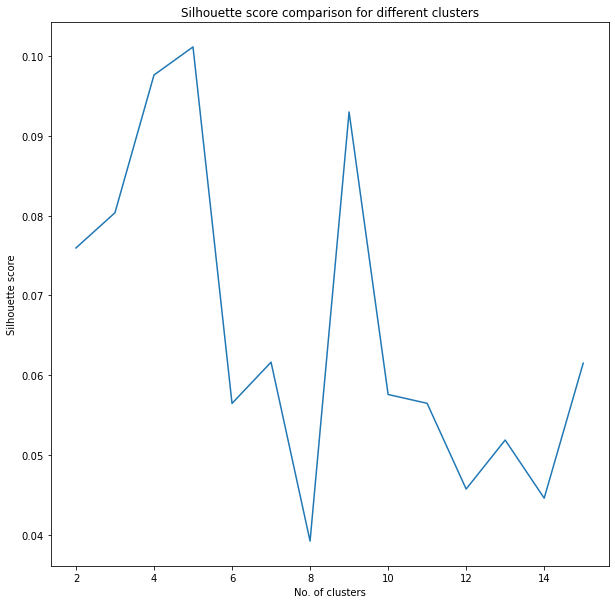

In [23]:
plt.figure(figsize = (10,10))
plt.plot(k, score)
plt.xlabel('No. of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score comparison for different clusters')
plt.show()

Now, we train kmeans algorithm again with k = 4.

In [24]:
n_cluster = score.index(max(score)) + 1
print(n_cluster)

km = KMeans(n_clusters = n_cluster, random_state = 0)
km.fit(X)

km.labels_[0:10]

4


array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

<br> We will arrange the data in such a way to see which venues are more popular in a neighborhood. We obtain top 10 venues in each neighborhood and store it in a dataframe. 

In [25]:
def sort(df, top):
    to_sort = df.iloc[1:]
    res = to_sort.sort_values(ascending = False)
    
    return res.index.values[0:top]

In [26]:
top = 10
 
indicators = ['st', 'nd', 'rd']
col = ['Neighborhood', 'Cluster Label']

for i in range(1,top+1):
    try:
        col.append(str(i) + indicators[i] + ' Most Common Venue')
    except:
        col.append(str(i) + 'th' + ' Most Common Venue')
        
final = pd.DataFrame(columns = col)
final['Neighborhood'] = grouped_df['Neighborhood']
final['Cluster Label'] = km.labels_

for i in np.arange(grouped_df.shape[0]):
    final.iloc[i,2:] = sort(X.iloc[i,:], top)
    
final.head()

,Neighborhood,Cluster Label,1nd Most Common Venue,2rd Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarey Milk Colony,0,Pizza Place,Café,Liquor Store,Yoga Studio,Farmers Market,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
1,Agripada,0,Bakery,Pool,Garden,Coffee Shop,Yoga Studio,Farm,Food,Flower Shop,Flea Market,Fish Market
2,Altamount Road,0,Café,Snack Place,Restaurant,Salon / Barbershop,Coffee Shop,Bakery,Japanese Restaurant,Chinese Restaurant,Clothing Store,Sandwich Place
3,Amboli,0,Coffee Shop,Park,Sandwich Place,Pharmacy,Pizza Place,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Fish Market,Field
4,Amrut Nagar,0,Hotel,Bakery,Café,Snack Place,Dessert Shop,Ice Cream Shop,Health & Beauty Service,Farm,Food & Drink Shop,Food


In [27]:
def getcolor(df):
    colors = []
    for i in range(len(df)):
        if df[i] == 0:
            colors.append('blue')
        elif df[i] == 1:
            colors.append('red')
        elif df[i] == 2:
            colors.append('green')
        elif df[i] == 3:
            colors.append('yellow')
            
    return colors

In [28]:
colors = getcolor(final['Cluster Label'])
final.insert(2, 'Cluster Color', colors)
final.head()

,Neighborhood,Cluster Label,Cluster Color,1nd Most Common Venue,2rd Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarey Milk Colony,0,blue,Pizza Place,Café,Liquor Store,Yoga Studio,Farmers Market,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
1,Agripada,0,blue,Bakery,Pool,Garden,Coffee Shop,Yoga Studio,Farm,Food,Flower Shop,Flea Market,Fish Market
2,Altamount Road,0,blue,Café,Snack Place,Restaurant,Salon / Barbershop,Coffee Shop,Bakery,Japanese Restaurant,Chinese Restaurant,Clothing Store,Sandwich Place
3,Amboli,0,blue,Coffee Shop,Park,Sandwich Place,Pharmacy,Pizza Place,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Fish Market,Field
4,Amrut Nagar,0,blue,Hotel,Bakery,Café,Snack Place,Dessert Shop,Ice Cream Shop,Health & Beauty Service,Farm,Food & Drink Shop,Food


In [29]:
final = data.merge(final, on = 'Neighborhood')
final.head()

,Neighborhood,Region,Latitude,Longitude,Cluster Label,Cluster Color,1nd Most Common Venue,2rd Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,Western Suburbs,19.1291,72.8464,0,blue,Coffee Shop,Park,Sandwich Place,Pharmacy,Pizza Place,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Fish Market,Field
1,"Chakala, Andheri",Western Suburbs,19.1084,72.8623,0,blue,Hotel,Indian Restaurant,Restaurant,Café,Falafel Restaurant,Gym,Bakery,Seafood Restaurant,Ice Cream Shop,Asian Restaurant
2,D.N. Nagar,Western Suburbs,19.1251,72.8325,0,blue,Smoke Shop,Gym / Fitness Center,Bus Line,Bar,Indian Restaurant,Pub,Pizza Place,Farmers Market,Food & Drink Shop,Food
3,Four Bungalows,Western Suburbs,19.1264,72.8242,0,blue,Café,Vegetarian / Vegan Restaurant,Pub,Bar,Indian Restaurant,Pizza Place,Pharmacy,Market,Residential Building (Apartment / Condo),Cocktail Bar
4,Lokhandwala,Western Suburbs,19.1432,72.8249,0,blue,Indian Restaurant,Bakery,Café,Donut Shop,Pharmacy,Falafel Restaurant,Garden,Dessert Shop,Bengali Restaurant,Chinese Restaurant


### Visualization of the Clustered Data

As can be seen from the map, only 2 clusters seem to be dominating the dataset. So, the clusters aren't uniform.

In [30]:
cluster_map = folium.Map(location  = [mum_lat, mum_lng], zoom_start = 10.5)

for lat, lng, neigh, clust, col in zip(final['Latitude'], final['Longitude'], final['Neighborhood'], final['Cluster Label'], final['Cluster Color']):
    label = folium.Popup(neigh + ' Cluster:' + str(clust))
    folium.CircleMarker(
        [lat, lng],
        radius = 3,
        color = col,
        fill = True,
        fill_opacity = 0.9
    ).add_to(cluster_map)
    
cluster_map

In [31]:
final['Cluster Label'].value_counts()

0    65
3    22
2     2
1     2
Name: Cluster Label, dtype: int64

<br>We now see the different types of restaurants in the dataset. This will help in targeting or suggesting a specific type of restaurant to be opened in the region.

In [32]:
temp = venue_data.Category.unique()

for element in temp:
    if element.find('Restaurant') != -1:
        print(element)

Indian Restaurant
Chinese Restaurant
Fast Food Restaurant
Falafel Restaurant
Asian Restaurant
Seafood Restaurant
Restaurant
Vegetarian / Vegan Restaurant
Japanese Restaurant
Bengali Restaurant
South Indian Restaurant
Middle Eastern Restaurant
Italian Restaurant
Greek Restaurant
New American Restaurant
Dim Sum Restaurant
Mughlai Restaurant
Mexican Restaurant
French Restaurant
Thai Restaurant
North Indian Restaurant
Tex-Mex Restaurant
Sushi Restaurant
Punjabi Restaurant
Cantonese Restaurant
Maharashtrian Restaurant
Mediterranean Restaurant
Parsi Restaurant
Multicuisine Indian Restaurant


### Analyzing Individual Clusters

<br>

#### Cluster 0
<br>
These places are filled with restaurants with most neighborhoods having 3-4 restaurants in their top 10 venues. So, this cluster seems like a good one for restaurants. But opening a restaurant anywhere in this cluster would not be a good idea. Since, there are already many restaurants in the region, there will be a lot of competition and not much profit. So, we will target the neighborhoods that doesn't seem to have a lot of restaurants. Some such places are <b>D.N.Nagar</b> , <b>Four Bungalows</b> , <b>Dava Bazaar</b> .

In [33]:
cluster0 = final.loc[final['Cluster Label'] == 0, final.columns[[0] + list(range(6, final.shape[1]))]].reset_index()
cluster0

,index,Neighborhood,1nd Most Common Venue,2rd Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Amboli,Coffee Shop,Park,Sandwich Place,Pharmacy,Pizza Place,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Fish Market,Field
1,1,"Chakala, Andheri",Hotel,Indian Restaurant,Restaurant,Café,Falafel Restaurant,Gym,Bakery,Seafood Restaurant,Ice Cream Shop,Asian Restaurant
2,2,D.N. Nagar,Smoke Shop,Gym / Fitness Center,Bus Line,Bar,Indian Restaurant,Pub,Pizza Place,Farmers Market,Food & Drink Shop,Food
3,3,Four Bungalows,Café,Vegetarian / Vegan Restaurant,Pub,Bar,Indian Restaurant,Pizza Place,Pharmacy,Market,Residential Building (Apartment / Condo),Cocktail Bar
4,4,Lokhandwala,Indian Restaurant,Bakery,Café,Donut Shop,Pharmacy,Falafel Restaurant,Garden,Dessert Shop,Bengali Restaurant,Chinese Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
60,86,Matunga,Indian Restaurant,Café,Ice Cream Shop,Snack Place,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Bookstore,Clothing Store,Flower Shop
61,87,Parel,Indian Restaurant,Hotel,Stadium,Coffee Shop,Recording Studio,Chinese Restaurant,Restaurant,Roof Deck,Maharashtrian Restaurant,Lounge
62,88,Gowalia Tank,Coffee Shop,Restaurant,Café,Snack Place,Hotel,Bookstore,Deli / Bodega,Park,Farmers Market,Fast Food Restaurant
63,89,Dava Bazaar,Train Station,Snack Place,Asian Restaurant,Café,Food Truck,Coffee Shop,Yoga Studio,Fast Food Restaurant,Food & Drink Shop,Food


#### Cluster 1
<br>
There are only 2 Neighborhoods in this cluster so it's easier to analyze this cluster. There is one Restaurant as the most common venue. Also, we can see a beach in the most common venue. Having a restaurant around beach is always profitable. But, we can see that there is a lack of restaurants in this rergion. So, opening a restaurant in this region would be a profitable business.

In [34]:
cluster1 = final.loc[final['Cluster Label'] == 1, final.columns[[0] + list(range(6, final.shape[1]))]].reset_index()
cluster1

,index,Neighborhood,1nd Most Common Venue,2rd Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,11,Uttan,Beach,Convenience Store,Yoga Studio,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field
1,80,Navy Nagar,Asian Restaurant,Convenience Store,Yoga Studio,Farmers Market,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market


#### Cluster 2
<br>
These regions have no restaurants in their top 10 venues. There are small food courts and eating places but no proper restaurant. So, this doesn't seem like a good place for restaurants as there are no good factors to open one here. So, opening a restaurant here would not be recommended.

In [35]:
cluster2 = final.loc[final['Cluster Label'] == 2, final.columns[[0] + list(range(6, final.shape[1]))]].reset_index()
cluster2

,index,Neighborhood,1nd Most Common Venue,2rd Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6,Sahar,Hotel,Café,Department Store,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field
1,37,Asalfa,Hotel,Factory,Farmers Market,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field


#### Cluster 3
<br>
This cluster is also full of restaurants especially Indian restaurants. So, Indian restaurants are profitable in this cluster. But since all the neighborhoods have Indian restaurants in abundance, it wouldn't be recommended to open another one as there will be no real profits.<br><br>
But places like <b>Dagdi Chawl</b>, <b>Mahim</b>,  <b>Dongri</b> seem to lack other type of restaurants. So, opening a non-Indian restaurant in this place is an idea worth considering.

In [36]:
cluster3 = final.loc[final['Cluster Label'] == 3, final.columns[[0] + list(range(6, final.shape[1]))]].reset_index()
cluster3

,index,Neighborhood,1nd Most Common Venue,2rd Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,Marol,Indian Restaurant,Bakery,Hotel,Ice Cream Shop,Bus Station,Gym,Snack Place,Vegetarian / Vegan Restaurant,Diner,Coffee Shop
1,13,Kherwadi,Indian Restaurant,Restaurant,General Entertainment,Seafood Restaurant,Sports Club,Bar,Bakery,Café,Pizza Place,Tunnel
2,15,I.C. Colony,Indian Restaurant,Dessert Shop,Ice Cream Shop,Chinese Restaurant,Bakery,Gym,Bar,Coffee Shop,Fast Food Restaurant,Juice Bar
3,21,Juhu,Indian Restaurant,Coffee Shop,Lounge,Restaurant,Spa,Juice Bar,Fast Food Restaurant,Farmers Market,Hotel,Café
4,31,Naigaon,Hotel,Department Store,Bus Station,Indian Restaurant,Spa,Fast Food Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market
5,33,Irla,Indian Restaurant,Electronics Store,Café,Hotel,Smoke Shop,Pizza Place,Convenience Store,Coffee Shop,Chinese Restaurant,Fast Food Restaurant
6,34,Vile Parle,Hotel,Indian Restaurant,Sandwich Place,Bakery,Café,Nightclub,Gym,Pizza Place,Lounge,Restaurant
7,40,Nehru Nagar,Playground,Indian Restaurant,Office,Yoga Studio,Falafel Restaurant,Food,Flower Shop,Flea Market,Fish Market,Field
8,44,Indian Institute of Technology Bombay campus,Indian Restaurant,Café,Arcade,Pizza Place,Lake,Pub,Sushi Restaurant,Donut Shop,Bed & Breakfast,Seafood Restaurant
9,48,Deonar,Music Venue,Indian Restaurant,Chinese Restaurant,Farm,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Field
